In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np

class MNISTDataset(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(
            root='./data', 
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))  
            ])
        )
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        flattened_image = image.view(-1)
        return flattened_image, label

train_dataset = MNISTDataset(train=True)
test_dataset = MNISTDataset(train=False)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch.nn as nn
import torch.optim as optim
class Autoencoder(nn.Module):
    def __init__(self, k=16):  
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),  
            nn.ReLU(),
            nn.Linear(128, k)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(k, 128), 
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

def train_autoencoder(model, train_loader, num_epochs=10, device='cuda'):  
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 2 == 0:  
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder(k=16)  
train_autoencoder(model, train_loader, num_epochs=10, device=device)

Epoch [2/10], Average Loss: 0.560685
Epoch [4/10], Average Loss: 0.538955
Epoch [6/10], Average Loss: 0.532317
Epoch [8/10], Average Loss: 0.527790
Epoch [10/10], Average Loss: 0.524706


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def get_mnist_data_for_pca(dataloader):
    all_data = []
    for images, _ in dataloader:
        all_data.append(images.numpy())
    return np.vstack(all_data)

train_data = get_mnist_data_for_pca(train_loader)
test_data = get_mnist_data_for_pca(test_loader)

k = 16
pca = PCA(n_components=k)
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.transform(test_data)


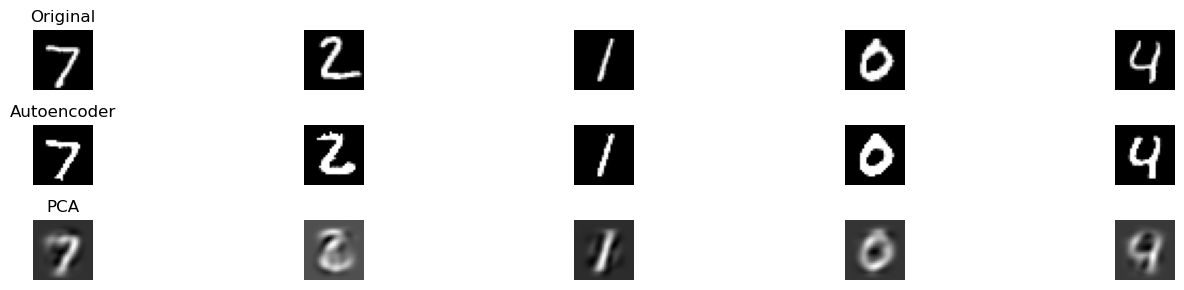

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_reconstructions(original, ae_reconstructed, pca_reconstructed, n_images=5):
    plt.figure(figsize=(15, 3))
    
    for i in range(n_images):
        # Original
        plt.subplot(3, n_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title('Original')
        plt.axis('off')
        
        # Autoencoder 
        plt.subplot(3, n_images, i + 1 + n_images)
        plt.imshow(ae_reconstructed[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title('Autoencoder')
        plt.axis('off')
        
        # PCA 
        plt.subplot(3, n_images, i + 1 + 2*n_images)
        plt.imshow(pca_reconstructed[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title('PCA')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def get_reconstructions(model, data_loader, device, n_samples=1000):
    model.eval()
    originals = []
    ae_reconstructed = []
    
    with torch.no_grad():
        for data, _ in data_loader:
            if len(originals) >= n_samples:
                break
            data = data.to(device)
            output = model(data)
            
            originals.append(data.cpu().numpy())
            ae_reconstructed.append(output.cpu().numpy())
            
    return (np.vstack(originals)[:n_samples], 
            np.vstack(ae_reconstructed)[:n_samples])

# Get samples and their reconstructions
n_samples = 1000
originals, ae_reconstructed = get_reconstructions(model, test_loader, device, n_samples)
pca_reconstructed = pca.inverse_transform(pca.transform(originals))

# Plot reconstructions
plot_reconstructions(originals, f, pca_reconstructed)

